### Importing Libraries 

In [7]:
# Importing Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import tree
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn import tree
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron

### Reading the dataset

In [8]:
# Reading the training data 
df = pd.read_csv("./train_data_withlabels.csv")

# Showing the training data 
df.head()

,Unnamed: 0,load,ac,ev,oven,wash,dryer,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst
0,105541,2.245,0,0,0,0,0,0,Sun,0.987,0.987,6.215,3.074549,0.678886,0.052903,0.994071
1,105542,2.259,0,0,0,0,0,0,Sun,0.014,0.014,6.215,3.172867,0.667450,0.054829,0.994154
2,105543,2.269,0,0,0,0,0,0,Sun,0.010,0.010,6.215,3.270112,0.647777,0.056991,0.994220
3,105544,2.268,0,0,0,0,0,0,Sun,-0.001,0.001,6.215,3.303763,0.629227,0.057606,0.994150
4,105545,2.270,0,0,0,0,0,0,Sun,0.002,0.002,6.215,3.302744,0.621295,0.082640,0.994041


In [9]:
# Reading the test data 
df_test = pd.read_csv("./test_data_nolabels.csv")

# Dropping the unwanted column 
df_test_mod = df_test.drop(columns=['Unnamed: 0'])

# labels, uniques = pd.factorize(df_test_mod.loc[:,"dayofweek"].values)
# df_test_mod.loc[:, "dayofweek"] = labels

# Displaying the test dataframe 
df_test_mod.head()

,load,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst
0,1.869,0,Mon,0.000,0.000,0.0,0.0,0.0,0.0,0.0
1,1.673,0,Mon,-0.196,0.196,0.0,0.0,0.0,0.0,0.0
2,1.660,0,Mon,-0.013,0.013,0.0,0.0,0.0,0.0,0.0
3,1.772,0,Mon,0.112,0.112,0.0,0.0,0.0,0.0,0.0
4,1.679,0,Mon,-0.093,0.093,0.0,0.0,0.0,0.0,0.0


## Exploratory Data Analysis

In [32]:
# Grouping by day of the week and hour of the day and finding the mean of the same 
grouped_df = df.groupby(['dayofweek','hourofday']).mean()

In [33]:
# Resetting the index of the dataframe 
grouped_df = grouped_df.reset_index()

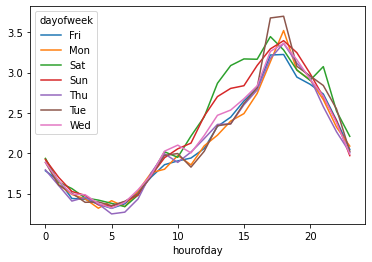

In [34]:
# Using pivot() function to reshape the data and plotting 
grouped_df.pivot(index="hourofday", columns="dayofweek", values="load").plot()
plt.show()

Observation: 

1. The mean "load" trend throughout each day of the week follows a pattern as shown above. 
2. The green and red lines seems to slightly stand apart from the rest. The green line stands for Saturday while the red line stands for Sunday. It could be since they dipict the load trends on the weekends. 
3. The mean load on Tuesday seems to be the highest somewhere between 3PM to 7PM . 

### Check for class imbalance

<AxesSubplot:>

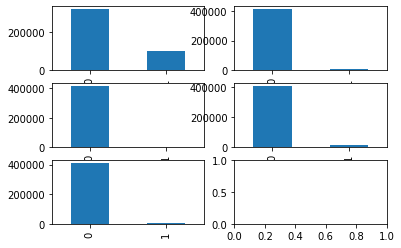

In [35]:
# Plots to check for Class Imbalance 
fig, axes = plt.subplots(nrows=3, ncols=2)

# Using value_counts() function to check the series of unique 
df.ac.value_counts().plot(kind="bar", ax=axes[0,0])
df.ev.value_counts().plot(kind="bar", ax=axes[1,0])
df.oven.value_counts().plot(kind="bar", ax=axes[2,0])
df.wash.value_counts().plot(kind="bar", ax=axes[0,1])
df.dryer.value_counts().plot(kind="bar", ax=axes[1,1])

Observation:

1. None of the target variables have a balanced class. 
2. The classes are imbalanced. To deal with this problem, we can use a resampling technique. In our models, we have first implemented oversampling of the minority class label data, followed by undersampling of the majority data, trying to balance them out.

## Correlation

### Correlation between Independent Variables 

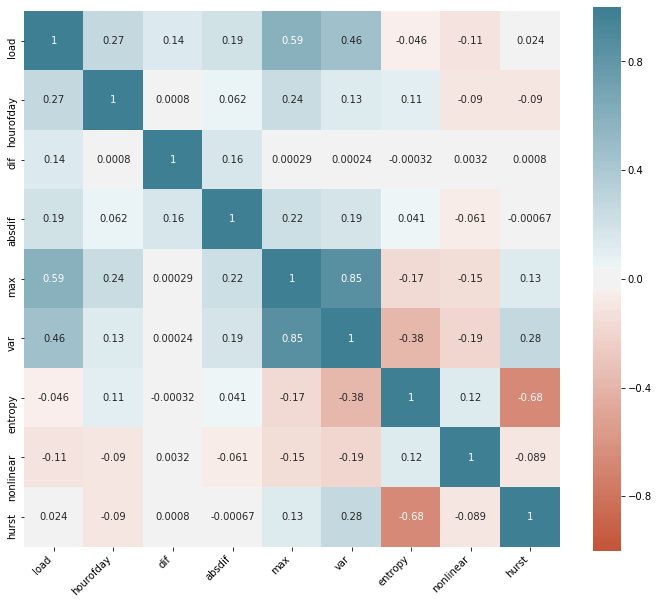

In [10]:
# Plotting a heatmap using seaborn library
corr = df.drop(columns=['Unnamed: 0','ac','ev','oven','wash','dryer']).corr()
plt.figure(figsize=(12,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Positive correlation

1. The variables that exhibit strong positive correlation with each other are :

    a) max and var
    

2. The variables that exhibit moderate positive correlation with each other:

    a) var and load
    
    b) max and load
    

3. The variables that exhibit weak positive correlation with each other:

    There are many. Few of which are:
    
    a) load and dif
    
    b) load and absdif
    
    c) hourofday and absdif


### Negative correlation

1. The variables that exhibit strong negative correlation with each other:

    a) entropy and hurst
    

2. The variables that exhibit moderate negative correlation with each other:

    a) entropy and var
    

3. The variables that exhibit weak negative correlation with each other:

    There are many. Few of which are:

    a) nonlinear and load
    
    b) hourofday and hurst
    
    c) var and nonlinear
    
    
We will be focusing on just the strong positive and strong negative correlations here to eliminate the use of variables.

### Correlation between Independent and Dependent Variables

### AC

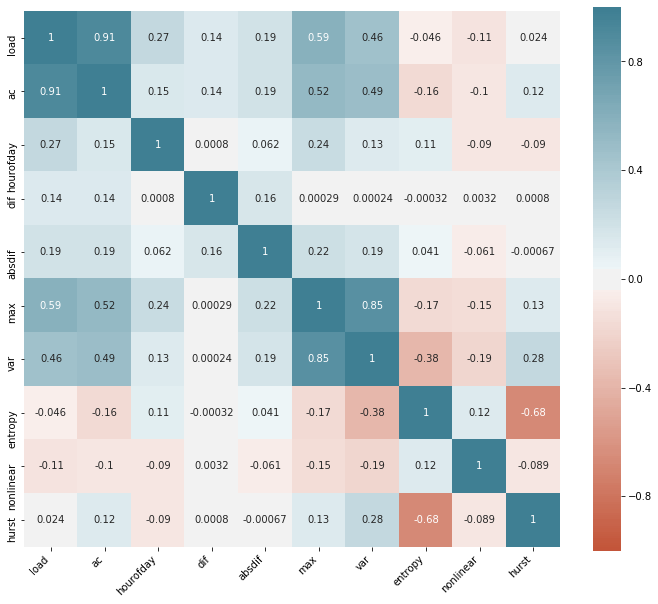

In [11]:
corr = df.drop(columns=['Unnamed: 0','ev','oven','wash','dryer']).corr()
plt.figure(figsize=(12,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

For "ac" appliance, the features strongly and moderately correlated with the response variable are:
    1. load
    2. max
    3. var


### EV

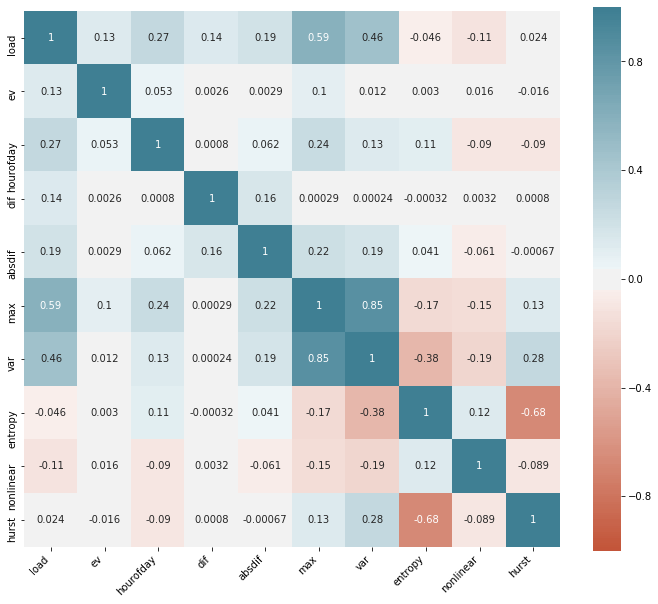

In [12]:
corr = df.drop(columns=['Unnamed: 0','ac','oven','wash','dryer']).corr()
plt.figure(figsize=(12,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

None of the features are neither strongly positively or negatively correlated to ev

### Oven

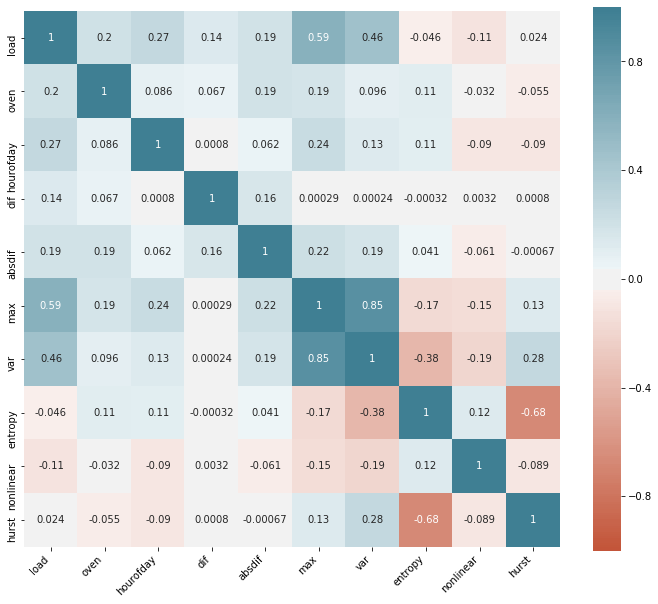

In [13]:
corr = df.drop(columns=['Unnamed: 0','ac','ev','wash','dryer']).corr()
plt.figure(figsize=(12,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

None of the features are neither strongly positively or negatively correlated to oven

### Wash

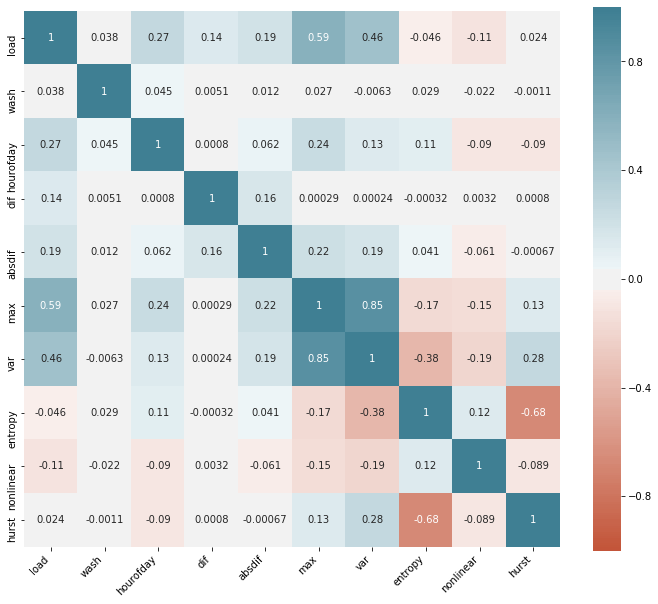

In [14]:
corr = df.drop(columns=['Unnamed: 0','ac','ev','oven','dryer']).corr()
plt.figure(figsize=(12,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

None of the features are neither strongly positively or negatively correlated to wash

### Dryer

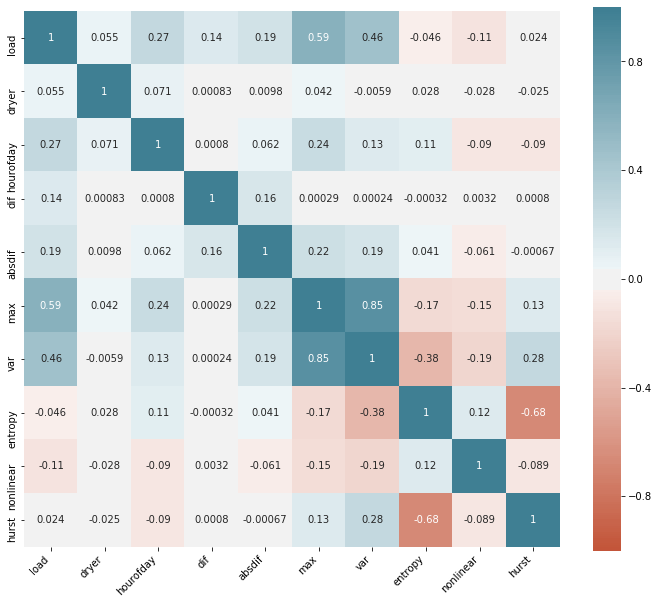

In [15]:
corr = df.drop(columns=['Unnamed: 0','ac','ev','oven','wash']).corr()
plt.figure(figsize=(12,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

None of the features are neither strongly positively or negatively correlated to dryer

Observation: 

1. For the response variables (ev, oven, wash and dryer), there are no features that seem to be correlate to each one of them. Here, more features need to be extracted inorder to predict the response variables more effectively. 

## Categorical Feature Encoding
Converting dayofweek from categorical data type to numerical. Similar to one-hot encoding. 

In [36]:
# Feature Engineering function 
def feature_engineering(df):
    
    # get_dummies() function to convert the categorical values into dummy variables
    dayofweek = pd.get_dummies(df['dayofweek'], prefix='dayofweek')
    df[dayofweek.columns] = dayofweek
    df = df.drop('dayofweek', axis=1)
    
    return df

## Model Selection for each of the response variables

In [37]:
# Creating function to get model statistics
def get_stats(y_):
    x_ = x[x_columns]
    
    # Statistics using the OLS Model 
    results = sm.OLS(y_, x_.astype(float)).fit()
    print(results.summary())

In [38]:
x = feature_engineering(df)

# Dropping the unwanted column
x_columns = x.drop(['Unnamed: 0', 'ac','ev','oven','wash', 'dryer'], axis=1).columns

# Converting to a list format 
x_columns = list(x_columns)
x_columns

['load',
 'hourofday',
 'dif',
 'absdif',
 'max',
 'var',
 'entropy',
 'nonlinear',
 'hurst',
 'dayofweek_Fri',
 'dayofweek_Mon',
 'dayofweek_Sat',
 'dayofweek_Sun',
 'dayofweek_Thu',
 'dayofweek_Tue',
 'dayofweek_Wed']

### AC

In [39]:
y = df['ac'].values

In [40]:
# Getting the OLS model for the AC
get_stats(y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                 1.748e+05
Date:                Sun, 30 May 2021   Prob (F-statistic):               0.00
Time:                        17:28:59   Log-Likelihood:             1.7589e+05
No. Observations:              417720   AIC:                        -3.518e+05
Df Residuals:                  417704   BIC:                        -3.516e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
load              0.2165      0.000   1301.860

The variables which have values less than 0.05 (alpha value) in the column **"P>|t|"** are significant. 

For predicting the response variable 'ac', we will be needing just the load, hourofday, dif, absdif, max, var, entropy, nonlinear and hurst 

In [41]:
ac_variables = x_columns
ac_variables

['load',
 'hourofday',
 'dif',
 'absdif',
 'max',
 'var',
 'entropy',
 'nonlinear',
 'hurst',
 'dayofweek_Fri',
 'dayofweek_Mon',
 'dayofweek_Sat',
 'dayofweek_Sun',
 'dayofweek_Thu',
 'dayofweek_Tue',
 'dayofweek_Wed']

### EV

In [42]:
x = feature_engineering(df)

x_columns = x.drop(['Unnamed: 0', 'ac','ev','oven','wash', 'dryer'], axis=1).columns

# Convertign column names into a list
x_columns = list(x_columns)
x_columns

['load',
 'hourofday',
 'dif',
 'absdif',
 'max',
 'var',
 'entropy',
 'nonlinear',
 'hurst',
 'dayofweek_Fri',
 'dayofweek_Mon',
 'dayofweek_Sat',
 'dayofweek_Sun',
 'dayofweek_Thu',
 'dayofweek_Tue',
 'dayofweek_Wed']

In [43]:
y = df['ev'].values

In [44]:
# Getting the OLS model for the EV
get_stats(y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1174.
Date:                Sun, 30 May 2021   Prob (F-statistic):               0.00
Time:                        17:29:03   Log-Likelihood:             5.0039e+05
No. Observations:              417720   AIC:                        -1.001e+06
Df Residuals:                  417704   BIC:                        -1.001e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
load              0.0041   7.65e-05     53.068

Observation: 

1. Since the R-squared value is really very low, which means that the relationship between the independent variables and dependent variables are explained only to the extent of 4%, there is no need select the features here.
2. The hour of day has a p value of 0.353 which is not less than 0.05 but it does not make a difference since R squared value is quite low.

### Oven

In [45]:
x = feature_engineering(df)

# Dropping unwanted columns 
x_columns = x.drop(['Unnamed: 0', 'ac','ev','oven','wash', 'dryer'], axis=1).columns

# Converting into list format 
x_columns = list(x_columns)
x_columns

['load',
 'hourofday',
 'dif',
 'absdif',
 'max',
 'var',
 'entropy',
 'nonlinear',
 'hurst',
 'dayofweek_Fri',
 'dayofweek_Mon',
 'dayofweek_Sat',
 'dayofweek_Sun',
 'dayofweek_Thu',
 'dayofweek_Tue',
 'dayofweek_Wed']

In [46]:
y = df['oven'].values

In [47]:
# Getting the model statistics using the OLS model for the Oven appliance 
get_stats(y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     2708.
Date:                Sun, 30 May 2021   Prob (F-statistic):               0.00
Time:                        17:29:08   Log-Likelihood:             3.1740e+05
No. Observations:              417720   AIC:                        -6.348e+05
Df Residuals:                  417704   BIC:                        -6.346e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
load              0.0064      0.000     54.036

This is similar to the previous model we saw. Only 9% of the relationship is explained. 

### Wash

In [48]:
x = feature_engineering(df)

# Dropping the unwanted columns
x_columns = x.drop(['Unnamed: 0', 'ac','ev','oven','wash', 'dryer'], axis=1).columns

# Converting into a list format 
x_columns = list(x_columns)
x_columns

['load',
 'hourofday',
 'dif',
 'absdif',
 'max',
 'var',
 'entropy',
 'nonlinear',
 'hurst',
 'dayofweek_Fri',
 'dayofweek_Mon',
 'dayofweek_Sat',
 'dayofweek_Sun',
 'dayofweek_Thu',
 'dayofweek_Tue',
 'dayofweek_Wed']

In [49]:
y = df['wash'].values

In [50]:
# Getting the statistics from the OLS Model for Wash 
get_stats(y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     294.3
Date:                Sun, 30 May 2021   Prob (F-statistic):               0.00
Time:                        17:29:11   Log-Likelihood:             2.4084e+05
No. Observations:              417720   AIC:                        -4.816e+05
Df Residuals:                  417704   BIC:                        -4.815e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
load              0.0016      0.000     11.308

This is similar to the previous model we saw. Only 1% of the relationship is explained. 

#### Dryer

In [51]:
x = feature_engineering(df)

# Dropping unwanted columns 
x_columns = x.drop(['Unnamed: 0', 'ac','ev','oven','wash', 'dryer'], axis=1).columns

# Converting into list 
x_columns = list(x_columns)
x_columns

['load',
 'hourofday',
 'dif',
 'absdif',
 'max',
 'var',
 'entropy',
 'nonlinear',
 'hurst',
 'dayofweek_Fri',
 'dayofweek_Mon',
 'dayofweek_Sat',
 'dayofweek_Sun',
 'dayofweek_Thu',
 'dayofweek_Tue',
 'dayofweek_Wed']

In [52]:
y = df['dryer'].values

In [53]:
# Getting the OLS statistics for the Dryer Appliance 
get_stats(y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     466.7
Date:                Sun, 30 May 2021   Prob (F-statistic):               0.00
Time:                        17:29:17   Log-Likelihood:             1.3331e+05
No. Observations:              417720   AIC:                        -2.666e+05
Df Residuals:                  417704   BIC:                        -2.664e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
load              0.0028      0.000     15.377

This is similar to the previous model we saw. Only 2% of the relationship is explained. 

## Auxilary functions

In [54]:
# Function for selecting features in the dataframe
def component(comp):
    filtered_y = df.loc[:, comp]
    filtered_x = df.drop(columns=['Unnamed: 0', 'ac', 'ev', 'oven', 'wash', 'dryer'])
    return(filtered_x, filtered_y)

In [55]:
# Function to split train and test 
def split_train_test(comp): 
    feature_x, feature_y = component(comp)
    X_train, X_test, y_train, y_test = train_test_split(feature_x, feature_y, random_state=42)
    return(X_train, X_test, y_train, y_test)

# Model Development 

## Model 1: Logistic Regression

Explanation: 

1. We are considering logistic regression because the distribution of the load seen in EDA resembles a sigmoid curve.
2. We are using Ridge Regression since all the features have equal importance.


In [56]:
# Logistic Regression 
def LR(train_x, train_y, test_x, test_y, validation=True):
        # Defining a pipeline 
        model = LogisticRegression(random_state=0, max_iter=500)
        
        # Oversampling function to solve imbalanced data
        over = SMOTE(sampling_strategy=0.5, k_neighbors=7)
        under = RandomUnderSampler(sampling_strategy=0.5)
        steps = [('over', over), ('under', under), ('model', model)]
        pipeline = Pipeline(steps=steps)
        
        # Standardising 
        scaler = preprocessing.StandardScaler().fit(train_x)
        X_scaled_train = scaler.transform(train_x)

        # Fitting the model 
        model.fit(X_scaled_train, train_y)
        pred = model.predict(test_x)
        
        # Calculating the accuracy and F1 Score
        if (validation):
            
            # evaluate pipeline
            cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
            scores = cross_val_score(pipeline, X_scaled_train, train_y, scoring='roc_auc', cv=cv, n_jobs=-1)
            print('Mean ROC AUC: %.3f' % np.mean(scores))
            print('LR accuracy = {}'.format(model.score(test_x, test_y)))
            print("F1 Score: {}".format(f1_score(test_y, pred, average='weighted')))

        else:
            
            return(pred)

### AC

In [37]:
X_train, X_test, y_train, y_test = split_train_test('ac')

In [38]:
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

Test_X = feature_engineering(df_test_mod)

In [39]:
# Obtaining the accuracy and the F1 Score through logistic regression for AC appliance 
LR(X_train, y_train, X_test, y_test, True)

Mean ROC AUC: 0.997
LR accuracy = 0.9302690797663506
F1 Score: 0.9328095486453044


In [40]:
lr_test_ac = LR(X_train, y_train, Test_X, y_test, False)

### EV

In [41]:
X_train, X_test, y_train, y_test = split_train_test('ev')

In [42]:
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

Test_X = feature_engineering(df_test_mod)

In [43]:
# Obtaining the accuracy and the F1 Score through logistic regression for EV appliance 
LR(X_train, y_train, X_test, y_test, True)

Mean ROC AUC: 0.950
LR accuracy = 0.40488365412237864
F1 Score: 0.5698578009336992


In [44]:
lr_test_ev = LR(X_train, y_train, Test_X, y_test, False)

### Oven

In [45]:
X_train, X_test, y_train, y_test = split_train_test('oven')

In [46]:
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

Test_X = feature_engineering(df_test_mod)

In [47]:
# Obtaining the accuracy and the F1 Score through logistic regression for Oven appliance 
LR(X_train, y_train, X_test, y_test, True)

Mean ROC AUC: 0.955
LR accuracy = 0.26047112898592356
F1 Score: 0.39430338101791185


In [48]:
lr_test_oven = LR(X_train, y_train, Test_X, y_test, False)

### Wash

In [49]:
X_train, X_test, y_train, y_test = split_train_test('wash')

In [50]:
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

Test_X = feature_engineering(df_test_mod)

In [51]:
# Obtaining the accuracy and the F1 Score through logistic regression for Wash appliance 
LR(X_train, y_train, X_test, y_test, True)

Mean ROC AUC: 0.715
LR accuracy = 0.6327204826199369
F1 Score: 0.758605962006361


In [52]:
lr_test_wash = LR(X_train, y_train, Test_X, y_test, False)

### Dryer

In [53]:
X_train, X_test, y_train, y_test = split_train_test('dryer')

In [54]:
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

Test_X = feature_engineering(df_test_mod)

In [55]:
# Obtaining the accuracy and the F1 Score through logistic regression for Dryer appliance 
LR(X_train, y_train, X_test, y_test, True)

Mean ROC AUC: 0.705
LR accuracy = 0.4430527626161065
F1 Score: 0.5837910837795114


In [56]:
lr_test_dryer = LR(X_train, y_train, Test_X, y_test, False)

## Model 2: Perceptron 

A Perceptron is a supervised learning technique for binary classifiers. This approach allows neurones to learn and process individual components in the training set.

In [57]:
# Function for perceptron 
def my_perceptron(x_train, x_test, y_train, y_test, validation=True):
        # define pipeline
        model = Perceptron(tol=1e-3, random_state=0, penalty='l2')
        over = SMOTE(sampling_strategy=0.5, k_neighbors=7)
        under = RandomUnderSampler(sampling_strategy=0.5)
        steps = [('over', over), ('under', under), ('model', model)]
        pipeline = Pipeline(steps=steps)
        
        # Scaling the data
        scaler = preprocessing.StandardScaler().fit(x_train)
        X_scaled_train = scaler.transform(x_train)
        model.fit(X_scaled_train, y_train)
        pred = model.predict(x_test)
            
        if (validation):
            # Evaluate pipeline
            cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
            scores = cross_val_score(pipeline, X_scaled_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
            print('Mean ROC AUC: %.3f' % np.mean(scores))
            print('Perceptron accuracy = {}'.format(model.score(x_test, y_test)))
            print("F1 Score: {}".format(f1_score(y_test, pred, average='weighted')))

        else:
            
            return(pred)

### AC

In [ ]:
X_train, X_test, y_train, y_test = split_train_test('ac')

X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

Test_X = feature_engineering(df_test_mod)

# Using my_perceptron function
my_perceptron(X_train, X_test, y_train, y_test, True)

perceptron_pred_ac = my_perceptron(X_train, Test_X, y_train, y_test, False)

Mean ROC AUC: nan


### EV

In [59]:
X_train, X_test, y_train, y_test = split_train_test('ev')

X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

Test_X = feature_engineering(df_test_mod)

my_perceptron(X_train, X_test, y_train, y_test, True)

perceptron_pred_ev = my_perceptron(X_train, Test_X, y_train, y_test, False)

Mean ROC AUC: 0.895
Perceptron accuracy = 0.381719812314469
F1 Score: 0.5458863875108082


### Oven

In [60]:
X_train, X_test, y_train, y_test = split_train_test('oven')

X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

Test_X = feature_engineering(df_test_mod)

my_perceptron(X_train, X_test, y_train, y_test, True)

perceptron_pred_oven = my_perceptron(X_train, Test_X, y_train, y_test, False)

Mean ROC AUC: 0.899
Perceptron accuracy = 0.20047878961984103
F1 Score: 0.31349547700992564


### Wash

In [61]:
X_train, X_test, y_train, y_test = split_train_test('wash')

X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

Test_X = feature_engineering(df_test_mod)

my_perceptron(X_train, X_test, y_train, y_test, True)

perceptron_pred_wash = my_perceptron(X_train, Test_X, y_train, y_test, False)

Mean ROC AUC: 0.612
Perceptron accuracy = 0.9691563726898401
F1 Score: 0.966820110185601


### Dryer

In [62]:
X_train, X_test, y_train, y_test = split_train_test('dryer')

X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

Test_X = feature_engineering(df_test_mod)

my_perceptron(X_train, X_test, y_train, y_test, True)

perceptron_pred_dryer = my_perceptron(X_train, Test_X, y_train, y_test, False)

Mean ROC AUC: 0.589
Perceptron accuracy = 0.09904242076031791
F1 Score: 0.13135825958159436


## Model 3: Decision Tree

As the name suggests, it uses tree like structure. In which the leaf node corresponds to a class label and the interior node of the tree represents attributes.

In [27]:
# Creating a function for Decision Tree 
def d_tree(x_train, x_test, y_train, y_test, validation=True):
    
    # Define pipeline
    model = DecisionTreeClassifier()

    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    # Finding the accuracy and F1 Score 
    if (validation):
        print('Perceptron accuracy = {}'.format(model.score(x_test, y_test)))
        print("F1 Score: {}".format(f1_score(y_test, pred, average='weighted')))
    else:
        return(pred)

### AC

In [28]:
X_train, X_test, y_train, y_test = split_train_test('ac')
d_tree(X_train, X_test, y_train, y_test, True)
# prediction for ac
d_tree_ac = d_tree(X_train, df_test_mod, y_train, y_test, False)

NameError: name 'split_train_test' is not defined

### EV

In [ ]:
X_train, X_test, y_train, y_test = split_train_test('ev')
d_tree(X_train, X_test, y_train, y_test, True)
# prediction for ev
d_tree_ev = d_tree(X_train, df_test_mod, y_train, y_test, False)

### Oven

In [ ]:
X_train, X_test, y_train, y_test = split_train_test('oven')
d_tree(X_train, X_test, y_train, y_test, True)
# prediction for oven
d_tree_oven = d_tree(X_train, df_test_mod, y_train, y_test, False)

### Wash

In [ ]:
X_train, X_test, y_train, y_test = split_train_test('wash')
d_tree(X_train, X_test, y_train, y_test, True)
# prediction for wash
d_tree_wash = d_tree(X_train, df_test_mod, y_train, y_test, False)

### Dryer

In [ ]:
X_train, X_test, y_train, y_test = split_train_test('dryer')
d_tree(X_train, X_test, y_train, y_test, True)
# prediction for dryer 
d_tree_dryer = d_tree(X_train, df_test_mod, y_train, y_test, False)

## Model 4: Random Forest

A random forest is a collection of decision trees that aggregates many predictions from each decision tree rather than relying on a single attribute. Hence, it can prevent from overfitting.

In [ ]:
# Model for Random Forest 
lr = RandomForestClassifier(max_depth=4, random_state=0, 
                            criterion='entropy', min_samples_split=4, 
                            class_weight="balanced_subsample", max_features='log2')

### AC

In [ ]:
X_train, X_test, y_train, y_test = split_train_test('ac')

X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)
Test_X = feature_engineering(df_test_mod)


lr.fit(X_train, y_train)

# Printing the accuracy of AC appliance using the Random Forest Model 
print("accuracy: {}".format(lr.score(X_test, y_test)))

pred = lr.predict(X_test)

# Printing the F1 Score of the AC appliance using thw Random Forest Model 
print("F1 Score: {}".format(f1_score(y_test, pred, average='weighted')))

In [ ]:
# Predicting values for AC using Random Forest 
pred_ac_rr = lr.predict(Test_X)

### EV

In [ ]:
X_train, X_test, y_train, y_test = split_train_test('ev')

X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)
Test_X = feature_engineering(df_test_mod)


print("accuracy: {}".format(lr.score(X_test, y_test)))

pred = lr.predict(X_test)

print("F1 Score: {}".format(f1_score(y_test, pred, average='weighted')))

In [ ]:
# Predicting values for EV using Random Forest 
pred_ev_rr = lr.predict(Test_X)

### Oven

In [ ]:
X_train, X_test, y_train, y_test = split_train_test('oven')

X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)
Test_X = feature_engineering(df_test_mod)

print("accuracy: {}".format(lr.score(X_test, y_test)))

pred = lr.predict(X_test)

print("F1 Score: {}".format(f1_score(y_test, pred, average='weighted')))

In [ ]:
# Predicting values for Oven using Random Forest 
pred_oven_rr = lr.predict(Test_X)

### Wash

In [ ]:
X_train, X_test, y_train, y_test = split_train_test('wash')

X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)
Test_X = feature_engineering(df_test_mod)


print("accuracy: {}".format(lr.score(X_test, y_test)))

pred = lr.predict(X_test)

print("F1 Score: {}".format(f1_score(y_test, pred, average='weighted')))

In [ ]:
# Predicting values for Wash using Random Forest 
pred_wash_rr = lr.predict(Test_X)

### Dryer

In [ ]:
X_train, X_test, y_train, y_test = split_train_test('dryer')

X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)
Test_X = feature_engineering(df_test_mod)


print("accuracy: {}".format(lr.score(X_test, y_test)))

pred = lr.predict(X_test)

print("F1 Score: {}".format(f1_score(y_test, pred, average='weighted')))

In [ ]:
# Predicting values for Dryer using Random Forest 
pred_dryer_rr = lr.predict(Test_X)

## Final stage

1. LR with l2 regularization generalizes better for 'ac', 'wash' and 'dryer' based on F1 Scores 

2. Random Forest generalizes better for 'ev' and 'oven' based on F1 Scores

Hence, we will be considering the above 2 models for predicting each appliances. 

In [2]:
# Selected prediction are chosen from the best performing models to get the high accuracy rate.
df_test.loc[:, "ac"] = lr_test_ac
df_test.loc[:, "ev"] = pred_ev_rr
df_test.loc[:, "oven"] = pred_oven_rr
df_test.loc[:, "wash"] = lr_test_wash
df_test.loc[:, "dryer"] = lr_test_dryer
df_test

NameError: name 'lr_test_ac' is not defined

## Writing the data 

Here, we are adding the above selected column to the test data file and the changing the first column name as 'id'.

In [ ]:
final_data = df_test[['ac','ev','oven','wash','dryer']]
final_data.index=np.arange(1,len(final_data)+1)
final_data.index.name = 'id'

In [ ]:
# Writing the predictions into a new csv file 
final_data.to_csv("./predictions.csv", index=True)

## Summary:

1. From the above models, we can see that only Logistic Regression and Random Forest works well. 
2. Decision Tree is overfitting the model and Perceptron is underfitting.
3. Values of load column were showing s shape which is similar to sigmoid function i.e. LR works well.

## References: 
    
1. https://www.analyticsvidhya.com/blog/2017/03/imbalanced-data-classification/
2. https://stackoverflow.com/questions/50376990/modulenotfounderror-no-module-named-imblearn